##Set the environment

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 7.5 MB/s 
     |████████████████████████████████| 362 kB 64.4 MB/s 
     |████████████████████████████████| 1.2 MB 62.5 MB/s 
     |████████████████████████████████| 4.4 MB 45.5 MB/s 
     |████████████████████████████████| 101 kB 14.4 MB/s 
     |████████████████████████████████| 140 kB 75.7 MB/s 
     |████████████████████████████████| 212 kB 73.8 MB/s 
     |████████████████████████████████| 1.1 MB 63.2 MB/s 
     |████████████████████████████████| 596 kB 62.5 MB/s 
     |████████████████████████████████| 127 kB 78.0 MB/s 
     |████████████████████████████████| 271 kB 68.3 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
     |████████████████████████████████| 144 kB 78.1 MB/s 
     |████████████████████████████████| 6.6 MB 37.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10

In [ ]:
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

## Look at the data

In [ ]:
test_df = pd.read_csv(path/'u.data')
test_df.head()

,196\t242\t3\t881250949
0,186\t302\t3\t891717742
1,22\t377\t1\t878887116
2,244\t51\t2\t880606923
3,166\t346\t1\t886397596
4,298\t474\t4\t884182806


In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
#last_skywalker = np.array([0.98,0.9,-0.9])

In [ ]:
#user1 = np.array([0.9,0.8,-0.6])

In [ ]:
#(user1*last_skywalker).sum()

In [ ]:
#casablanca = np.array([-0.99,-0.3,0.8])

In [ ]:
#(user1*casablanca).sum()

In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [ ]:
#ratings.iloc[4]

## Make data loader

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [ ]:
len(dls.classes['title']) , len(dls.classes['user']) 

(1665, 944)

In [ ]:
n_users  = len(dls.classes['user'])

n_movies = len(dls.classes['title'])

n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [ ]:
user_factors.shape, movie_factors.shape

(torch.Size([944, 5]), torch.Size([1665, 5]))

In [ ]:
one_hot_3 = one_hot(3, n_users).float()
user_factors.t() @ one_hot_3#check third number

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [ ]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

## Collaborative Filtering from Scratch

In [ ]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        
        return (users * movies).sum(dim=1)

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [ ]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.371919,1.313460,00:13
1,1.095397,1.090162,00:11
2,0.982468,1.003652,00:06
3,0.855089,0.907152,00:06
4,0.765639,0.889513,00:07


##Advanced ways

In [ ]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])

        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.980795,0.997819,00:07
1,0.873814,0.905639,00:07
2,0.688293,0.874815,00:07
3,0.480917,0.875623,00:07
4,0.372463,0.879677,00:10


In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        
        return sigmoid_range(res, *self.y_range)

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.960926,0.950450,00:07
1,0.823003,0.876462,00:07
2,0.642411,0.870824,00:07
3,0.403926,0.892137,00:07
4,0.300417,0.899642,00:07


### Weight Decay

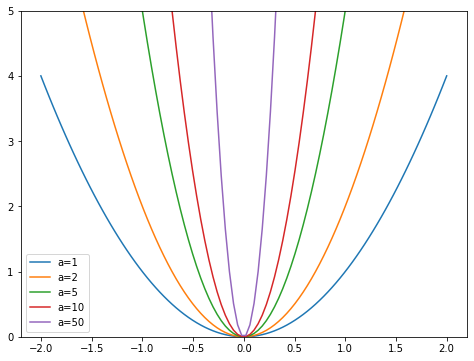

In [ ]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.937224,0.963885,00:07
1,0.836324,0.884583,00:07
2,0.763779,0.837741,00:07
3,0.625566,0.821824,00:08
4,0.494496,0.822900,00:07


## Deep Learning for Collaborative Filtering

In [ ]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [ ]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):

        self.user_factors = Embedding(*user_sz)
        
        self.item_factors = Embedding(*item_sz)

        self.layers = nn.Sequential(
            
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        
        self.y_range = y_range
        
    def forward(self, x):

        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [ ]:
model = CollabNN(*embs)

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.973393,0.959191,00:18
1,0.876695,0.903443,00:08
2,0.885746,0.885758,00:08
3,0.811935,0.877465,00:08
4,0.783010,0.879055,00:08


In [ ]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.976321,0.982631,00:09
1,0.903383,0.925149,00:09
2,0.856691,0.889491,00:10
3,0.812108,0.866788,00:10
4,0.762971,0.869692,00:09
